This module will process all the projects data and serve as a hub for team building. 
Algorithm flow:
1. Preprocess all project-related text
2. Create an project embedding matrix for all the matrix
3. Use cosine similarity score for ranking top related projects
4. Pull people worked in the top K projects, return a list of people (eId)
5. If there is not enough people, tab into people's similarity matrix for more people. **

In [216]:
import pandas as pd
import psycopg2
import matplotlib
import matplotlib.pyplot as plt
import re
import numpy as np
import nltk
import pickle
import seaborn as sns
from autocorrect import spell
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn import preprocessing
from nltk.stem import SnowballStemmer
from functools import reduce
sns.set(style="white")

plt.rcParams["figure.figsize"] = (10,8)

nltk.download('punkt', 'stopwords')

[nltk_data] Downloading package punkt to stopwords...
[nltk_data]   Package punkt is already up-to-date!


True

# 1. Data processing

## 1.1 Load the data

In [131]:
employee = pd.read_csv('../data/employee_M23.txt',sep = '|')
project = pd.read_csv('../data/Projects_M23.txt',sep = '|')
projectCategory = pd.read_csv('../data/Project_category_M23.txt',sep = '|')

In [11]:
print("Shape of employee table is (%d,%d)"%employee.shape)
print("Shape of project table is (%d,%d)"%project.shape)
print("Project categoryes is %s"%projectCategory.values)

Shape of employee table is (199,11)
Shape of project table is (594,6)
Project categoryes is [[1 'Business']
 [2 'Legal']
 [3 'Exam']
 [4 'Technology']
 [5 'Finacial']]


In [12]:
employee.head()

,ID,profilePictrueName,FirstName,LastName,Degree,YeasInCompany,Skills,PastProjectsID,Hobbies,ManagerId,Hub
0,12056,JudithAngulo,Judith,Angulo,MS,5,"BrokerCheck,Software Testing",1;100;200;300,Travel,12056,Technology
1,12057,JessicaBurns,Jessica,Burns,MS,5,variable annuities,2;101;201;301,Hiking,12057,Business
2,12058,TIMOTHYMurphy,TIMOTHY,Murphy,MS,5,AWS Big Data,3;102;202;302,Basketball,12058,QA
3,12059,StevenCanedy,Steven,Canedy,MS,5,Development Services,4;103;203;303,Volleyball,12059,QA
4,12060,GeraldSIDOTI,Gerald,SIDOTI,MS,5,Agile,5;104;204;304,Bike,12060,Analytics


In [147]:
employeeBaseInf = employee[['ID','FirstName','LastName','profilePictrueName']]

In [18]:
project.head()

,pID,ProjectName,ProjectTeam,ProjectOwner,ProjectDescription,ProjectCategoryId
0,1,Planning,"Jessica Burns,TIMOTHY Murphy,Steven Canedy,Ger...",Alesha Pasternak,"Workforce and Financial planning, reporting an...",1
1,2,slutions meeting,"TIMOTHY Murphy,Steven Canedy,Gerald SIDOTI,MIK...",Sung Mijangos,"Tax, Payment and Compliance Solution meeting",1
2,3,Travel planning,"Steven Canedy,Gerald SIDOTI,MIKE Cohen,Brooks ...",Phyliss Barrette,Travel Management is a provider of travel man...,1
3,4,Risk monitoring,"Gerald SIDOTI,MIKE Cohen,Brooks Santangelo,Rob...",Suk Bunn,firm review using analytics workspace,1
4,5,Registration,"MIKE Cohen,Brooks Santangelo,Robert Delise,Vil...",Eliz Dewall,reporting of registration statistics,1


## 1.2 preprocess the data
There are two data tables to be processed: 1. employee table 2. Project table

In [121]:
col2use = ['Degree','YeasInCompany','Skills','PastProjectsID','Hobbies','Hub']

In [122]:
employee.columns

Index(['ID', 'profilePictrueName', 'FirstName', 'LastName', 'Degree',
       'YeasInCompany', 'Skills', 'PastProjectsID', 'Hobbies', 'ManagerId',
       'Hub'],
      dtype='object')

In [141]:
# catFeatures = ['Degree','YeasInCompany','Hobbies','Hub']
# for feat in catFeatures:
#     employee[feat] = employee[feat].astype('category')
# employee[catFeatures] = employee[catFeatures].apply(lambda x: x.cat.codes)
# employee.head()

In [144]:
## Convert categorical features to one hot encoding
catFeatures = ['ID','Degree','YeasInCompany','Hobbies','Hub']
emplyeeCatFeaturesWithoutSkillsProjects = pd.get_dummies(employee[catFeatures], prefix_sep = '_', drop_first=True)
emplyeeCatFeaturesWithoutSkillsProjects.head()

,ID,YeasInCompany_2,YeasInCompany_3,YeasInCompany_4,YeasInCompany_5,YeasInCompany_6,YeasInCompany_7,YeasInCompany_9,YeasInCompany_11,YeasInCompany_12,...,Hobbies_Hiking,Hobbies_Reading,Hobbies_Swimming,Hobbies_Travel,Hobbies_Volleyball,Hub_Business,Hub_Machine Learning,Hub_Management,Hub_QA,Hub_Technology
0,12056,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,12057,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
2,12058,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,12059,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,12060,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
# massage employee skill data
emplyeeSkillsdata = pd.melt(employee[['ID','Skills']].set_index('ID')['Skills'].str.split(",", n = -1, expand = True).reset_index(),
              id_vars = ['ID'],
              value_name = 'Skills')\
        .dropna().drop(['variable'], axis = 1)\
        .groupby(['ID','Skills']).agg({'Skills':"count"})\
        .rename(columns={'Skills':'SkillsCount'}).reset_index()
emplyeeSkillsdata['SkillsCount'] = emplyeeSkillsdata['SkillsCount'].astype(np.int64)

In [90]:
emplyeeSkillsdata.head()

,ID,Skills,SkillsCount
0,12056,BrokerCheck,1
1,12056,Software Testing,1
2,12057,variable annuities,1
3,12058,AWS Big Data,1
4,12059,Development Services,1


In [100]:
emplyeeSkillsMatrix = pd.pivot_table(emplyeeSkillsdata, values = 'SkillsCount', 
                          index = 'ID', columns = 'Skills').reset_index()
emplyeeSkillsdataNoNan = emplyeeSkillsMatrix.fillna(0)
emplyeeSkillsdataNoNan.head()

Skills,ID,,.NET,ACATS,AWS,Artificial Intelligence,C++,CSS,D3,HTML,...,Web Content Management,WebADV,data,data management,data vault modeling,disaster recovery,drupal,iManage,scrumban,variable annuities
0,12056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,12058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Skill set distribution')

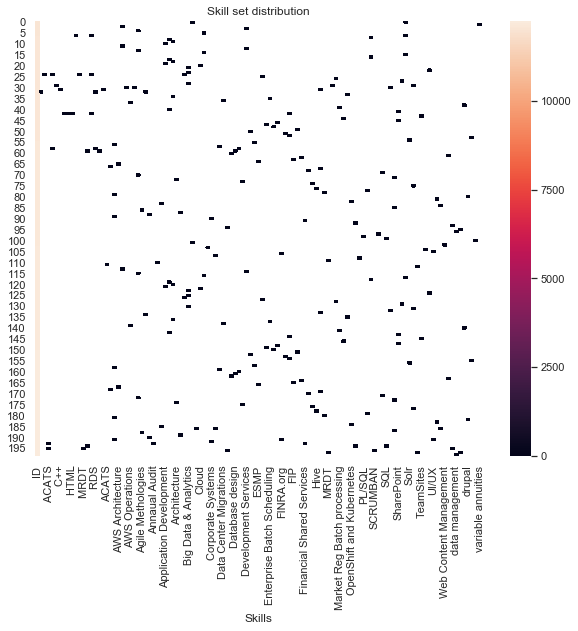

In [217]:
ax1 = plt.axes()
sns.heatmap(emplyeeSkillsMatrix, ax = ax1)
ax1.set_title('Skill set distribution')

In [98]:
# massage empolyee project data
projectData = pd.melt(employee[['ID','PastProjectsID']].set_index('ID')['PastProjectsID'].str.split(";", n = -1, expand = True).reset_index(),
              id_vars = ['ID'],
              value_name = 'PastProjectsID')\
        .dropna().drop(['variable'], axis = 1)\
        .groupby(['ID','PastProjectsID']).agg({'PastProjectsID':"count"})\
        .rename(columns={'PastProjectsID':'PastProjectsCount'}).reset_index()
projectData['PastProjectsCount'] = projectData['PastProjectsCount'].astype(np.int64)
projectDataMatrix = pd.pivot_table(projectData, values = 'PastProjectsCount', 
                          index = 'ID', columns = 'PastProjectsID').reset_index()
projectDataMatrixNoNan = projectDataMatrix.fillna(0)
projectDataMatrixNoNan.head()


PastProjectsID,ID,1,10,100,101,102,103,104,105,106,...,90,91,92,93,94,95,96,97,98,99
0,12056,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12057,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12058,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12059,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12060,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Project participation distribution')

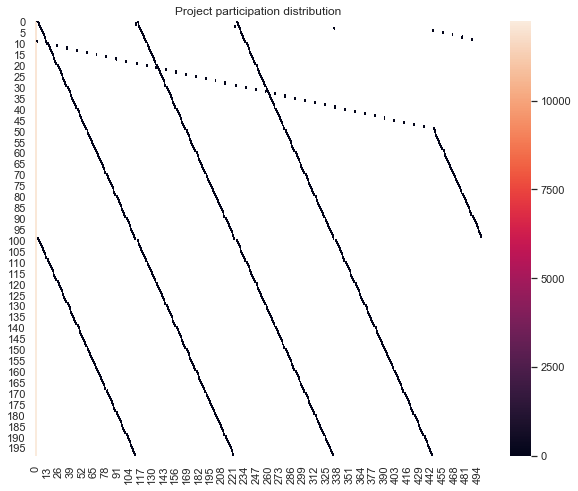

In [218]:
ax1 = plt.axes()
sns.heatmap(projectDataMatrix.values)
ax1.set_title('Project participation distribution')

In [172]:
# Join all the information for employe processed table
list_df = [employeeBaseInf,emplyeeCatFeaturesWithoutSkillsProjects,emplyeeSkillsdataNoNan,projectDataMatrixNoNan ]
employeeReady = reduce(lambda left, right: pd.merge(left, right, on = ['ID'], how = 'inner'), list_df)
employeeReady.shape
employeeReady.head()

,ID,FirstName,LastName,profilePictrueName,YeasInCompany_2,YeasInCompany_3,YeasInCompany_4,YeasInCompany_5,YeasInCompany_6,YeasInCompany_7,...,90,91,92,93,94,95,96,97,98,99
0,12056,Judith,Angulo,JudithAngulo,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12057,Jessica,Burns,JessicaBurns,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12058,TIMOTHY,Murphy,TIMOTHYMurphy,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12059,Steven,Canedy,StevenCanedy,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12060,Gerald,SIDOTI,GeraldSIDOTI,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [165]:
employeeReady.head()

TypeError: unsupported format string passed to numpy.ndarray.__format__

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [177]:
employeeNumericOnly = employeeReady.iloc[:,4:] # selection only numeric data
employeeNumericOnly.head()

,YeasInCompany_2,YeasInCompany_3,YeasInCompany_4,YeasInCompany_5,YeasInCompany_6,YeasInCompany_7,YeasInCompany_9,YeasInCompany_11,YeasInCompany_12,YeasInCompany_13,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Employee process numerical features')

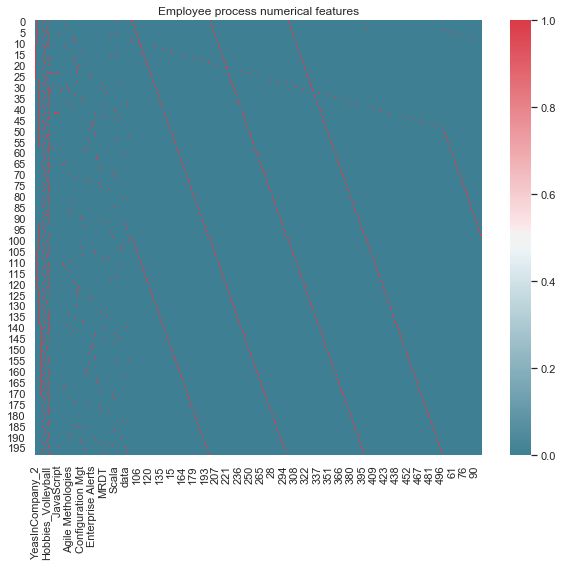

In [222]:
ax1 = plt.axes()
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(employeeNumericOnly,cmap = cmap, ax = ax1)
ax1.set_title('Employee process numerical features')

Text(0.5, 1.0, 'Employee similarity matrix')

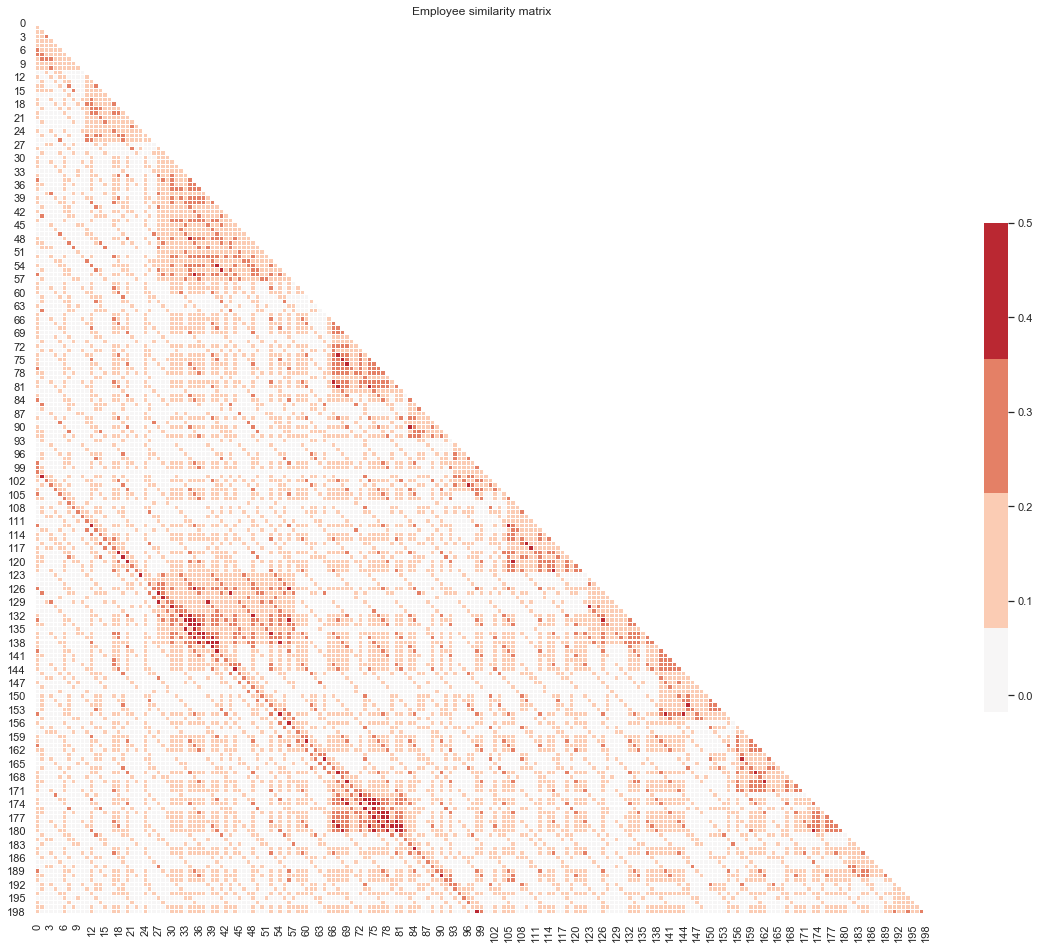

In [212]:
corr = np.corrcoef(employeeNumericOnly)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 18))
cmap = sns.color_palette("RdBu_r", 7)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,cmap = cmap,  vmax=.5, center=0,
            square=True, linewidths=0.01, cbar_kws={"shrink": .5})
ax.set_title('Employee similarity matrix')

# 2. Traning - team builder
This will create a project embedding matrix for all existing projects and take an project text input and returns the top K similar projects